> ##### - module import

In [1]:
import pandas as pd
import numpy as np

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import plotly.express as px

import pickle

from dateutil.parser import *

import warnings
warnings.filterwarnings('ignore')

/home/naru/.pyenv/versions/3.9.13/envs/py3.9.13/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> ##### - generate data #####

In [2]:
import pandas as pd

def generate_time_series( 
                         start_d : str, end_d : str, 
                         start_t : int, end_t : int, 
                         period : str
                         ):
    series = pd.date_range( start=start_d, end=end_d, freq='D' )
    
    df = pd.DataFrame( columns=['ds','y'])
    df.ds, df.y = series, 0
    
    tick = df.set_index('ds').resample( period ).count().reset_index()
    
    np.random.seed(42)
    tick.y = np.random.randint( 0, 10, size=(len(tick.ds)))
    
    tick['days'] = tick['ds'].dt.day_name()
    tick['hour'] = tick['ds'].dt.hour
    
    tick.loc[ (tick.days == 'Saturday') | (tick.days == 'Sunday'),  'y' ] = 0
    tick.loc[ (tick.hour < 9 ) | (tick.hour > 18 ), 'y' ] = 0
    
    return tick
    
    

gen_df = generate_time_series(
        start_d= '2019-01-01', end_d= '2021-01-01', 
        start_t= 9, end_t= 18, 
        period= '1T'
)

# gen_df.iloc[:-1,:-2]  
gen_df

single_fit_data =  gen_df.iloc[:,:-2].copy()
single_fit_data

,ds,y
0,2019-01-01 00:00:00,0
1,2019-01-01 00:01:00,0
2,2019-01-01 00:02:00,0
3,2019-01-01 00:03:00,0
4,2019-01-01 00:04:00,0
...,...,...
1052636,2020-12-31 23:56:00,0
1052637,2020-12-31 23:57:00,0
1052638,2020-12-31 23:58:00,0
1052639,2020-12-31 23:59:00,0


In [3]:
gen_df[(gen_df['ds'] >= '2019-01-01 09:00:00') & (gen_df['ds'] <= '2019-01-01 10:00:00')]

,ds,y,days,hour
540,2019-01-01 09:00:00,5,Tuesday,9
541,2019-01-01 09:01:00,6,Tuesday,9
542,2019-01-01 09:02:00,7,Tuesday,9
543,2019-01-01 09:03:00,9,Tuesday,9
544,2019-01-01 09:04:00,8,Tuesday,9
...,...,...,...,...
596,2019-01-01 09:56:00,1,Tuesday,9
597,2019-01-01 09:57:00,8,Tuesday,9
598,2019-01-01 09:58:00,0,Tuesday,9
599,2019-01-01 09:59:00,0,Tuesday,9


> ##### - append data #####

In [4]:
from dateutil.parser import *

def validation_data( ):
    
    date_list = [
        ( parse('2023-07-01 00:01:45'), 1 ), # 토요일 새벽 접속
        ( parse('2023-07-01 15:20:30'), 3 ), # 토요일 오후 13시 접속
        ( parse('2023-07-02 02:10:19'), 5 ), # 일요일 새벽 접속
        ( parse('2023-07-02 15:30:17'), 3 ), # 일요일 오후 13시 접속
        ( parse('2023-07-03 03:00:25'), 1 ), # 월요일 새벽 접속
        ( parse('2023-07-03 21:45:54'), 7 ), # 월요일 오후  9시 접속    
        ( parse('2023-07-04 15:51:19'), 6 ), # 화요일 오후  3시 접속
        ( parse('2023-07-04 20:32:31'), 2 ), # 화요일 오후  8시 접속
        ( parse('2023-07-05 11:56:43'), 4 ), # 수요일 오전 11시 접속
        ( parse('2023-07-05 15:14:08'), 4 ), # 수요일 오후  3시 접속
        ( parse('2023-07-06 12:17:09'), 8 ), # 목요일 오후 12시 접속
        ( parse('2023-07-06 14:17:09'), 4 ), # 목요일 오후  2시 접속
        ( parse('2023-07-06 19:19:11'), 1 ), # 목요일 저녁  7시 접속
        ( parse('2023-07-06 21:41:57'), 1 ), # 목요일 저녁  9시 접속
        ( parse('2023-07-07 09:21:54'), 2 ), # 금요일 오전  9시 접속
        ( parse('2023-07-07 20:34:21'), 9 ), # 금요일 저녁  8시 접속
        ( parse('2023-07-08 00:45:33'), 3 ), # 토요일 새벽 접속      
        ( parse('2023-07-08 17:45:53'), 5 ), # 토요일 오후  5시 접속
        ( parse('2023-07-08 17:45:35'), 1 ), # 토요일 새벽 접속      
    ]
    return pd.DataFrame( data=date_list, columns=['ds', 'y'] )

validation_data( )

,ds,y
0,2023-07-01 00:01:45,1
1,2023-07-01 15:20:30,3
2,2023-07-02 02:10:19,5
3,2023-07-02 15:30:17,3
4,2023-07-03 03:00:25,1
5,2023-07-03 21:45:54,7
6,2023-07-04 15:51:19,6
7,2023-07-04 20:32:31,2
8,2023-07-05 11:56:43,4
9,2023-07-05 15:14:08,4


In [ ]:
# from dateutil.parser import *

# date_list = [
#     ( parse('2020-07-01 00:01:45'), 1 ), # 토요일 새벽 접속
#     ( parse('2020-07-01 15:20:30'), 3 ), # 토요일 오후 13시 접속
#     ( parse('2020-07-02 02:10:19'), 5 ), # 일요일 새벽 접속
#     ( parse('2020-07-02 15:30:17'), 3 ), # 일요일 오후 13시 접속
#     ( parse('2020-07-03 00:00:25'), 1 ), # 월요일 새벽 접속
#     ( parse('2020-07-03 21:45:54'), 7 ), # 월요일 오후 9시 접속    
#     # ( parse('2023-07-04 15:45:54'), 6 ), # 화요일 오후 3시 접속 ( 정상 )
#     # ( parse('2023-07-04 20:45:54'), 2 ), # 화요일 오후 8시 접속
#     # ( parse('2023-07-05 11:45:54'), 4 ), # 수요일 오전 11시 접속 ( 정상 )
#     # ( parse('2023-07-08 00:45:54'), 1 ), # 토요일 새벽 접속      
# ]

# test_df = pd.DataFrame( data=date_list, columns=['ds', 'y'] )
# test_df

> ##### prepared test dataset

In [ ]:
dataset = pd.concat( [gen_df, test_df] )
dataset

In [ ]:
# dataset = dataset.reset_index( )
# dataset.tail(10)
dataset = dataset.set_index( 'ds' ).reset_index()
dataset

In [ ]:
dataset.drop(columns=['days', 'hour'], inplace=True)

In [ ]:
dataset.tail( 20 )

In [ ]:
dataset.loc[ (dataset.ds > parse('20201230000000')) & (dataset.y > 0) ].tail(20)

In [ ]:
dataset.shape

> ##### - set holidays #####

In [3]:
import pandas as pd
import holidays

def get_holidays( start, end ):

    series = pd.date_range( start=start, end=end, freq='D' )

    kr_holidays = holidays.KR()

    holiday_df = pd.DataFrame( columns=['ds','holiday'])
    holiday_df['ds'] = series

    holiday_df['holiday'] = holiday_df.ds.apply( lambda x: '1' if x in kr_holidays else '0' )

    holiday = holiday_df.loc[ holiday_df.holiday == '1', ].reset_index()[['holiday', 'ds']]
    holiday['holiday'] = holiday.holiday.apply( lambda x: 'holiday' if x == '1' else x )
    return holiday

In [ ]:
import pandas as pd
import holidays

series = pd.date_range( start='2019-01-01', end='2020-12-31', freq='D' )
series

kr_holidays = holidays.KR()

holiday_df = pd.DataFrame( columns=['ds','holiday'])
holiday_df['ds'] = series

holiday_df['holiday'] = holiday_df.ds.apply( lambda x: '1' if x in kr_holidays else '0' )

holiday_df.iloc[ :20 ,:], holiday_df.shape

holiday = holiday_df.loc[ holiday_df.holiday == '1', ].reset_index()[['holiday', 'ds']]
holiday['holiday'] = holiday.holiday.apply( lambda x: 'holiday' if x == '1' else x )
holiday

In [ ]:
result_dict.get('5T').get('anomaly_data')

> ##### Test #####

In [4]:
tick_list = [
    '5T',   #  5 min
    '10T',  # 10 min
    '30T',  # 30 min
    '1H'    #  1 hour
 ]

In [ ]:
result_dict = dict()
for period in tick_list:
    result_dict.update({ period :  make_model_and_run( dataset, period ) })   

> ##### - Test data # 3 #####

In [4]:
# 처음 부터 1분 tick 이므로 처 할 필요가 없음
# ts = single_fit_data.set_index('ds').y.resample( '1T' ).mean().reset_index()
ts = single_fit_data

In [5]:

# ts = ts.set_index('ds').resample('H').mean().reset_index()
# ts = ts.set_index('ds').resample('H').median().reset_index()
ts = ts.set_index('ds').resample('H').mean().reset_index()
ts.shape

(17545, 2)

In [7]:
ts.loc[ts.y > 0,]

,ds,y
9,2019-01-01 09:00:00,4.466667
10,2019-01-01 10:00:00,4.350000
11,2019-01-01 11:00:00,3.783333
12,2019-01-01 12:00:00,4.716667
13,2019-01-01 13:00:00,4.916667
...,...,...
17534,2020-12-31 14:00:00,4.216667
17535,2020-12-31 15:00:00,4.383333
17536,2020-12-31 16:00:00,4.550000
17537,2020-12-31 17:00:00,5.283333


In [ ]:
ts.head()

In [ ]:
ts.y.max()

In [ ]:
# remove value of y is 0
ts = ts.loc[ts.y != 0.0, ].reset_index()
ts.drop( columns=['index',], inplace=True)
ts

In [ ]:
ts['floor'] = 0
train = ts[(ts['ds'] < '2020-12-25')]
test = ts[(ts['ds'] >= '2020-12-25')]
print(f'trian.shape : {train.shape}')
print(f'test.shape : {test.shape}')

In [ ]:
# sns.set(rc={'figure.figsize':(12,8)})
# sns.scatterplot(x=ts['ds'], y=ts['y'])

# lower limit
# df['floor']=0

# model = Prophet(interval_width=0.99, daily_seasonality=True, weekly_seasonality=True)

m = Prophet(
    # interval_width=0.99, daily_seasonality=True, weekly_seasonality=True
    
    growth='linear',
    # growth='flat',
   
    # trend
    changepoint_range=0.95,    

    changepoint_prior_scale=10.0,
    
    interval_width = 0.8,
    
    mcmc_samples = 0,
    
    # seasonality
    # seasonality_mode='multiplicative',
    seasonality_mode='additive',
    # weekly_seasonality=10,
    # yearly_seasonality=10,
    # daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=False,
    daily_seasonality=True,
    
    # holiday
    # holidays=holiday,
    # holidays_prior_scale=15
)

m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m.fit(train)


In [ ]:
# future is test set 
# future = m.make_future_dataframe(periods=337, freq='30min')
t_periods = test.shape[0]
future = m.make_future_dataframe(periods=t_periods+123, freq='H')
future['floor'] = 0
future

In [ ]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

In [ ]:
forecast[['yhat', 'trend', 'additive_terms' ]]

In [ ]:

result = pd.concat([ts.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)

fig = m.plot( forecast  )

r2sult = result.reset_index()
result = r2sult.loc[ r2sult.ds < parse( '2020-12-01 13:00:00' ), ]
result

# result

In [ ]:
import matplotlib.pyplot as plt

plt.plot( result['y'].values, label='Actual')
plt.plot( result['yhat'].values, label='Predicted')
plt.legend()
plt.show()

In [ ]:

comp = m.plot_components( forecast )

In [ ]:
from prophet.plot import add_changepoints_to_plot

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
result.loc[result.y > 0, ]

In [ ]:
period = '1H'

result['error'] = result['y'] - result['yhat']
result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']

result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)

result.reset_index()

fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title=f'{period} tick graph')
fig.show()

anomaly_data = result.loc[result.anomaly == 'Yes',]

print( f'Anomaly data shape : {anomaly_data.shape}' )
anomaly_data

> ##### - test anomaly data per 1H #####

In [ ]:
test_df = validation_data()
test_df

In [ ]:
ats = test_df.set_index('ds').resample('H').mean().reset_index()
print(ats.shape)
ats.dropna(inplace=True)
ats

In [ ]:
forecast_ats = m.predict( ats )
forecast_ats[['ds','yhat','yhat_lower','yhat_upper']].tail()

In [ ]:
result_ats = pd.concat([ats.set_index('ds')['y'], forecast_ats.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)

fig = m.plot( forecast_ats  )


In [ ]:
period = '1H'

result_ats['error'] = result_ats['y'] - result_ats['yhat']
result_ats['uncertainty'] = result_ats['yhat_upper'] - result_ats['yhat_lower']

result_ats['anomaly'] = result_ats.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)

result_ats

result.reset_index()

fig = px.scatter(result_ats.reset_index(), x='ds', y='y', color='anomaly', title=f'{period} tick graph')
fig.show()

ats_data = result_ats.loc[result_ats.anomaly == 'Yes',]

print( f'Anomaly data shape : {ats_data.shape}' )
ats_data

In [ ]:
result_ats

In [ ]:
final = result_ats.reset_index()
final['days'] = final['ds'].dt.day_name()
final[['ds', 'days', 'y', 'yhat', 'yhat_lower', 'yhat_upper', 'error', 'uncertainty',
       'anomaly']]

> ##### test anomaly data per 30 T #####

- fit model

In [ ]:
ts_30T = single_fit_data
ts_30T = ts.set_index('ds').resample('30T').mean().reset_index()
ts_30T.shape

In [ ]:
train_30T = ts_30T[(ts_30T['ds'] < '2020-12-25')]
test_30T = ts_30T[(ts_30T['ds'] >= '2020-12-25')]

print( f'train_30T.shape : {train_30T.shape}' )
print( f'test_30T.shape : {test_30T.shape}'   )

In [ ]:
# sns.set(rc={'figure.figsize':(12,8)})
# sns.scatterplot(x=ts['ds'], y=ts['y'])

# lower limit
# df['floor']=0

# model = Prophet(interval_width=0.99, daily_seasonality=True, weekly_seasonality=True)

m_30T = Prophet(
    # interval_width=0.99, daily_seasonality=True, weekly_seasonality=True
    
# growth='linear',

    changepoint_range=0.95,    
   
    # trend
    changepoint_prior_scale=0.3,
    
    # seasonality
    weekly_seasonality=10,
    yearly_seasonality=10,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    # seasonality_mode='additive',
    
    # holiday
    holidays=holiday,
    holidays_prior_scale=15
)

m_30T.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m_30T.fit(train_30T)

In [ ]:
# future is test set 
# future = m.make_future_dataframe(periods=337, freq='30min')
future_30T = m_30T.make_future_dataframe(periods=337, freq='30min')
future_30T

In [ ]:
forecast_30T = m.predict(future_30T)
forecast_30T[['ds','yhat','yhat_lower','yhat_upper']].tail()

In [ ]:
result_30T = pd.concat([ts_30T.set_index('ds')['y'], forecast_30T.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)

fig_30T = m.plot( forecast_30T  )

In [ ]:
comp_30T = m_30T.plot_components( forecast_30T )

In [ ]:
from prophet.plot import add_changepoints_to_plot

fig_30T = m.plot(forecast_30T)
a_30T = add_changepoints_to_plot(fig_30T.gca(), m_30T, forecast_30T)

In [ ]:
period_30T = '30T'

result_30T['error'] = result_30T['y'] - result_30T['yhat']
result_30T['uncertainty'] = result_30T['yhat_upper'] - result_30T['yhat_lower']

result_30T['anomaly'] = result_30T.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)

result_30T.reset_index()

fig_30T = px.scatter(result_30T.reset_index(), x='ds', y='y', color='anomaly', title=f'{period} tick graph')
fig_30T.show()

anomaly_ats_data = result_30T.loc[result_30T.anomaly == 'Yes',]

print( f'Anomaly data shape : {anomaly_ats_data.shape}' )
anomaly_ats_data

- test data

In [ ]:
ats_30T = test_df.set_index('ds').resample('30T').mean().reset_index()
print(ats_30T.shape)
ats_30T.dropna(inplace=True)
ats_30T

In [ ]:
forecast_ats_30T = m.predict( ats_30T )
forecast_ats_30T[['ds','yhat','yhat_lower','yhat_upper']].tail()

In [ ]:
result_ats_30T = pd.concat([ats_30T.set_index('ds')['y'], forecast_ats_30T.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)

fig_ats_30T = m.plot( forecast_ats_30T  )

In [ ]:
period_ats_30T = '30T'

result_ats_30T['error'] = result_ats_30T['y'] - result_ats_30T['yhat']
result_ats_30T['uncertainty'] = result_ats_30T['yhat_upper'] - result_ats_30T['yhat_lower']

result_ats_30T['anomaly'] = result_ats_30T.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)

result_ats_30T

result.reset_index()

fig_ats_30T = px.scatter(result_ats_30T.reset_index(), x='ds', y='y', color='anomaly', title=f'{period_ats_30T} tick graph')
fig_ats_30T.show()

ats_30T_data = result_ats_30T.loc[result_ats_30T.anomaly == 'Yes',]

print( f'Anomaly data shape : {ats_30T_data.shape}' )
ats_30T_data

> ##### test anomaly data per 5T

> ##### - make model and run #####

- ##### interval_width
    ```yaml
    Prophet의 predict은    
    yhat_upper, yhat_lower 와 같은 불확실성 구간을 반환   
    이것은 불확실성 구간에만 영향을 미치고   
    예측 yhat을 전혀 변경하지 않으므로 조정할 필요 없음   
    ```

In [26]:
def run_to_predict(  ts, test_data, period :str, holiday ):   
    ts = ts.set_index('ds').resample( period ).mean().reset_index()
    
    ## if `growth=logistic'
    # # upper limit
    # ts['cap'] = ts.y.max()
    # # lower limit
    # ts['floor'] = 0.0

    # remove value of y is 0
    # ts = ts.loc[ts.y != 0.0, ].reset_index()
    # ts.drop( columns=['index',], inplace=True)

    # train = ts[(ts['ds'] < '2020-12-25')]
    # test = ts[(ts['ds'] >= '2020-12-25')]

    print( f'ts.shape : {ts.shape}' )
    # print( f'train.shape : {train.shape}' )
    # print( f'test.shape : {test.shape}' )
    
    m = Prophet(
        
        growth='linear',
        # growth='logistic',
        # growth='flat',
    
        ## trend
        # changepoints=None,
        # n_changepoints=25,
        changepoint_range=0.9,    
        changepoint_prior_scale=0.05,
        
        ## seasonality
        # seasonality_mode='multiplicative',
        seasonality_mode='additive', # additive
        seasonality_prior_scale=10.0, # 10
        daily_seasonality=10,
        weekly_seasonality=10,
        # daily_seasonality=True,
        # weekly_seasonality=True,
        # yearly_seasonality=True,
        
        ## holiday
        holidays=holiday,
        holidays_prior_scale=10,
        
        ## Others
        interval_width = 0.95,        
        # mcmc_samples = 300,
        # uncertainty_samples=1000,
        
    )

    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

    # m.fit(train)
    # 2 년치 훈련 전부함.
    m.fit(ts)

    ## if `growth=logistic'
    # test_data['cap'] = ts.y.max()
    # test_data['floor'] = 0.0
    
    ats = test_data.set_index('ds').resample( period ).mean().reset_index()
    print(ats.shape)
    ats.dropna(inplace=True)

    forecast = m.predict( ats )
    
    fig = m.plot( forecast  )
    m.plot_components(forecast)
    a = add_changepoints_to_plot(fig.gca(), m, forecast)
            
    forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

    result = pd.concat([ats.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)

    result['error'] = result['y'] - result['yhat']
    result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']

    # result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)
    # result['anomaly'] = result.apply(lambda x: 'Yes' if( np.abs(x['yhat_upper']) - np.abs(x['yhat_lower']) ) * 1.5 < ( np.abs(x['y']) - np.abs(x['yhat']) ) else 'No', axis = 1)
    # result['anomaly'] = result.apply(lambda x: 'Yes' if( np.abs(x['y']) - np.abs(x['yhat']) ) > ( np.abs(x['yhat_upper']) - np.abs(x['yhat_lower']) ) else 'No', axis = 1)
    result['anomaly'] = result.apply(lambda x: 'Yes' if( np.abs( np.abs(x['y']) - np.abs(x['yhat']) ) ) > np.abs( ( np.abs(x['yhat_upper']) - np.abs(x['yhat_lower']) ) ) else 'No', axis = 1)
    # def custom( hour, y, yhat, yupper, ylower ):
    #     print( f'index ds : [{hour}]')
    #     if 7 < hour < 23:
    #         return 'yes' if y > yupper + ylower * 1.5 else 'no'
    #     else:
    #         return 'yes' if y > yupper + ylower * 0.7 else 'no'
        
    result.reset_index( inplace=True)
    # result['anomaly'] = result.apply(lambda x: custom( x['ds'].hour, x['y'], x['yhat'], x['yhat_upper'], x['yhat_lower'] ), axis = 1 )
    # ( np.abs(final_df.y) - np.abs(final_df.yhat) ) - ( np.abs(final_df.yhat_upper) - np.abs(final_df.yhat_lower) ) 
        

    fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title=f'{period} tick graph')
    fig.show()

    ats_data = result.loc[result.anomaly == 'Yes',]

    print( f'Anomaly data shape : {ats_data.shape}' )
    
    final = result.reset_index()
    final['days'] = final['ds'].dt.day_name()
    final['hour'] = final.ds.dt.hour
    # final['right'] = final.apply( lambda x: ((x.days in ['Saturday', 'Sunday']) | ((x.hour >= 9) & (x.hour <= 18) ) ) == (x.anomaly == 'Yes'), axis=1)
    final['right'] = final.apply( lambda x: not ((x.days in ['Saturday', 'Sunday']) | ( x.hour not in range( 9, 19 )) ) ^ (x.anomaly == 'Yes'), axis=1)
    
    
    final = final[['ds', 'days', 'hour', 'y', 'yhat', 'yhat_lower', 'yhat_upper', 'error', 'uncertainty',
        'anomaly', 'right']]
    
    accuracy = final.loc[ final.right, ].shape[0] / final.shape[0] * 100
    
    return {
                'descript' : f'{period} tick test',
                'result'   : result,
                'final'    : final,
                'model'    : m,
                'accuracy' : accuracy,
                
            }

In [10]:
# fig10 = px.line( single_fit_data[-1000:], x='ds', y='y', title='Train data' )
# fig11 = px.scatter( single_fit_data[-10000:], x='ds', y='y', title='Train data' )
# fig10.show()
# fig11.show()

> ##### - run #####

ts.shape : (35089, 2)


01:50:31 - cmdstanpy - INFO - Chain [1] start processing
01:50:36 - cmdstanpy - INFO - Chain [1] done processing


(372, 2)


Anomaly data shape : (12, 8)


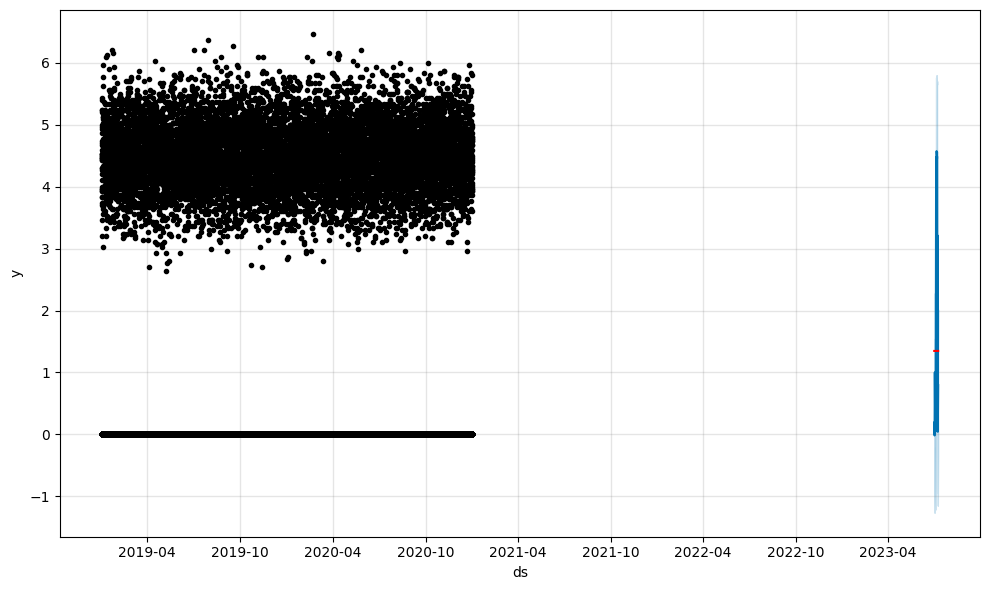

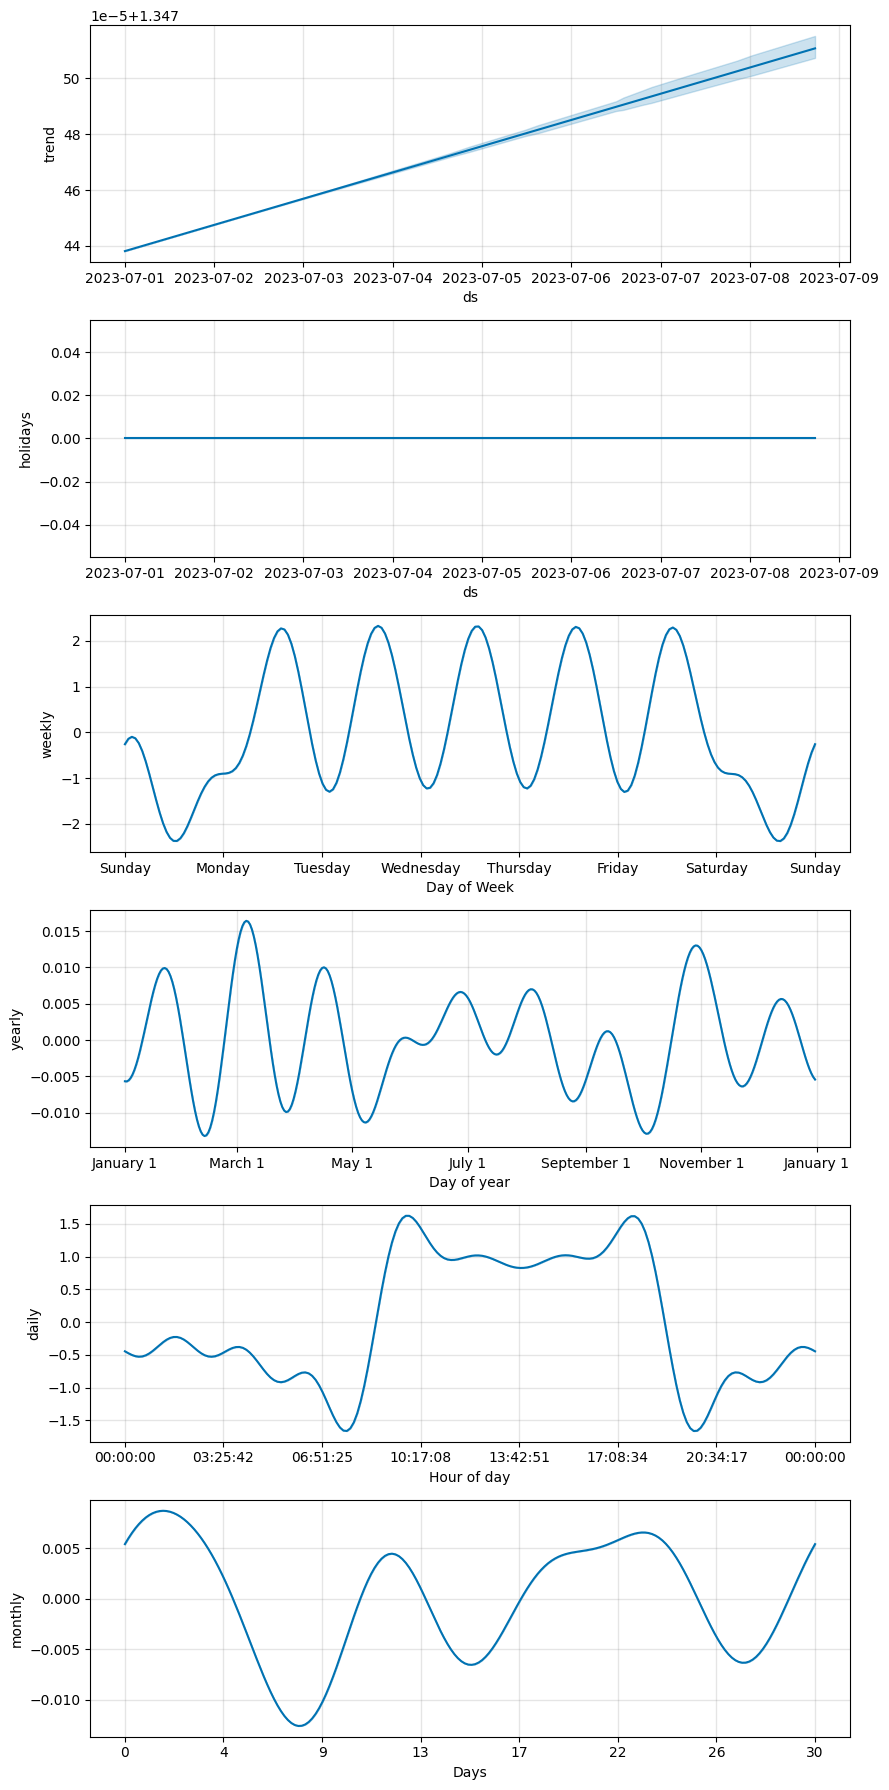

In [27]:
holiday = get_holidays( '2019-01-01', '2023-12-31' )

test_df = validation_data( )

result_dict =  run_to_predict(  single_fit_data, test_df, '30T', holiday )

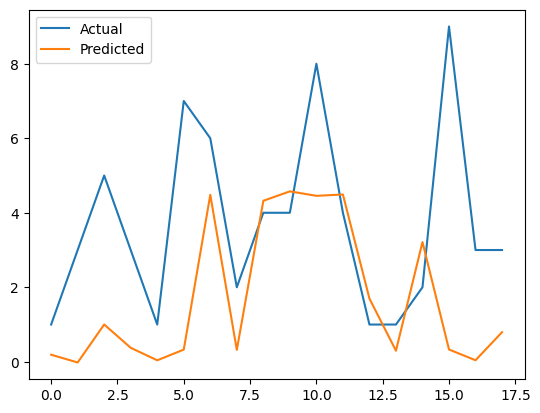

In [25]:
import matplotlib.pyplot as plt

plt.plot( result_dict.get('result')['y'].values, label='Actual')
plt.plot( result_dict.get('result')['yhat'].values, label='Predicted')
plt.legend()
plt.show()

In [23]:
result_dict.keys()

dict_keys(['descript', 'result', 'final', 'model', 'accuracy'])

In [24]:
accuracy = result_dict.get( 'accuracy' )
print( f'Accuracy : {accuracy} %' )

final_df = result_dict.get('final')
final_df

Accuracy : 33.33333333333333 %


,ds,days,hour,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly,right
0,2023-07-01 00:00:00,Saturday,0,1.0,0.190094,-0.925523,1.539790,0.809906,2.465313,yes,False
1,2023-07-01 15:00:00,Saturday,15,3.0,-0.018195,-1.266614,1.241714,3.018195,2.508329,yes,False
2,2023-07-02 02:00:00,Sunday,2,5.0,1.001329,-0.219736,2.281006,3.998671,2.500742,yes,False
3,2023-07-02 15:30:00,Sunday,15,3.0,0.375733,-0.854247,1.671773,2.624267,2.526020,yes,False
4,2023-07-03 03:00:00,Monday,3,1.0,0.040348,-1.216564,1.327273,0.959652,2.543837,yes,False
5,2023-07-03 21:30:00,Monday,21,7.0,0.327274,-0.854685,1.530859,6.672726,2.385544,yes,False
6,2023-07-04 15:30:00,Tuesday,15,6.0,4.482162,3.322683,5.766163,1.517838,2.443480,no,True
7,2023-07-04 20:30:00,Tuesday,20,2.0,0.319641,-0.947569,1.592852,1.680359,2.540421,yes,False
8,2023-07-05 11:30:00,Wednesday,11,4.0,4.321448,3.004848,5.554797,-0.321448,2.549948,no,True
9,2023-07-05 15:00:00,Wednesday,15,4.0,4.574358,3.337616,5.801650,-0.574358,2.464034,no,True


In [18]:
( np.abs(final_df.y) - np.abs(final_df.yhat) ) - np.abs( np.abs(final_df.yhat_upper) - np.abs(final_df.yhat_lower) )
# np.abs( final_df.yhat + final_df.y ) - np.abs( final_df.yhat_upper + final_df.yhat_lower )

0     0.287146
1     2.953392
2     2.071277
3     1.759660
4     0.915600
5     6.030934
6    -0.992833
7     1.085344
8    -2.908080
9    -2.927397
10    0.926928
11   -3.028219
12   -3.261445
13    0.161546
14   -3.718629
15    8.048289
16    2.906769
17    0.614824
dtype: float64

> ##### Validation Lines #####

- 직전 3개월 데이터 (23-01-01 ~ 23-3-31)
- test day ( 23-04-01 )

In [40]:

gen_3m_df = generate_time_series(
        start_d= '2023-01-01', end_d= '2023-04-01', 
        start_t= 9, end_t= 18, 
        period= '1T'
)

gen_3m_df.iloc[:-1,:-2]  
# gen_3m_df

single_3m_fit_data =  gen_3m_df.iloc[:-1,:-2].copy()
single_3m_fit_data

,ds,y
0,2023-01-01 00:00:00,0
1,2023-01-01 00:01:00,0
2,2023-01-01 00:02:00,0
3,2023-01-01 00:03:00,0
4,2023-01-01 00:04:00,0
...,...,...
129595,2023-03-31 23:55:00,0
129596,2023-03-31 23:56:00,0
129597,2023-03-31 23:57:00,0
129598,2023-03-31 23:58:00,0


In [36]:
from dateutil.parser import *

def validation_data_3m( ):
    
    date_list = [
        ( parse('2023-04-03 00:01:45'), 1 ),  # 월요일  0시 접속      
        ( parse('2023-04-03 09:11:05'), 5 ),  # 월요일  9시 접속      
        ( parse('2023-04-03 10:01:40'), 7 ),  # 월요일 10시 접속      
        ( parse('2023-04-03 11:31:55'), 8 ), # 월요일 11시 접속      
        ( parse('2023-04-03 12:09:22'), 3 ),  # 월요일 12시 접속      
        ( parse('2023-04-03 13:54:34'), 5 ),  # 월요일 13시 접속      
        ( parse('2023-04-03 14:16:17'), 7 ),  # 월요일 14시 접속      
        ( parse('2023-04-03 15:24:42'), 8 ),  # 월요일 15시 접속      
        ( parse('2023-04-03 16:53:35'), 4 ),  # 월요일 16시 접속      
        ( parse('2023-04-03 17:44:11'), 3 ),  # 월요일 17시 접속      
        ( parse('2023-04-03 18:16:16'), 1 ),  # 월요일 16시 이후 접속      
    ]
    return pd.DataFrame( data=date_list, columns=['ds', 'y'] )

validation_data_3m( )

,ds,y
0,2023-04-03 00:01:45,1
1,2023-04-03 09:11:05,5
2,2023-04-03 10:01:40,7
3,2023-04-03 11:31:55,8
4,2023-04-03 12:09:22,3
5,2023-04-03 13:54:34,5
6,2023-04-03 14:16:17,7
7,2023-04-03 15:24:42,8
8,2023-04-03 16:53:35,4
9,2023-04-03 17:44:11,3


ts.shape : (4320, 2)


16:12:19 - cmdstanpy - INFO - Chain [1] start processing
16:12:19 - cmdstanpy - INFO - Chain [1] done processing


(37, 2)


Anomaly data shape : (4, 7)


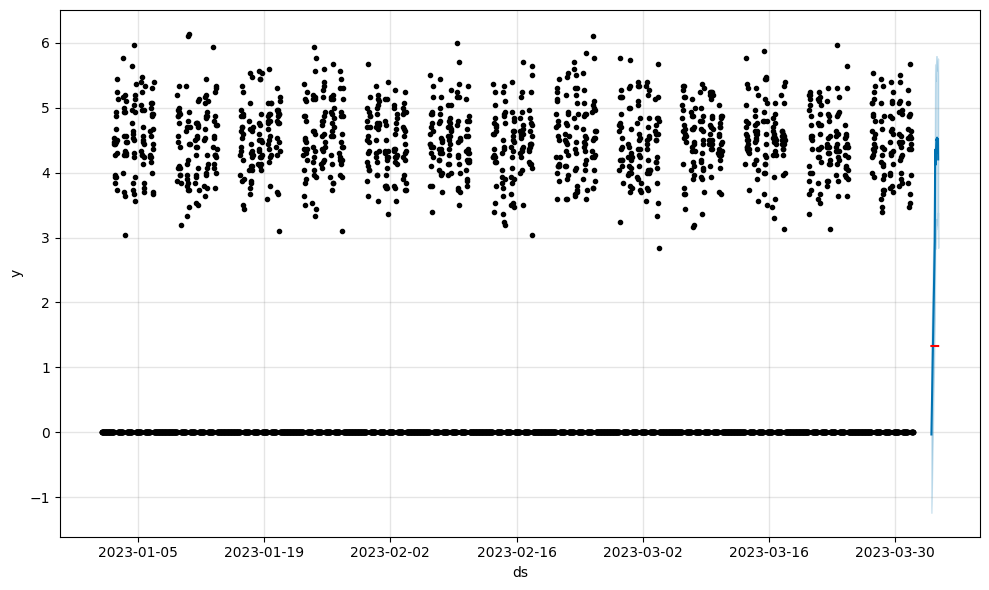

In [37]:
holiday_3m = get_holidays( '2019-01-01', '2023-12-31' )

test_df_3m = validation_data_3m( )

result_dict_3m =  run_to_predict(  single_3m_fit_data, test_df_3m, '30T', holiday_3m )

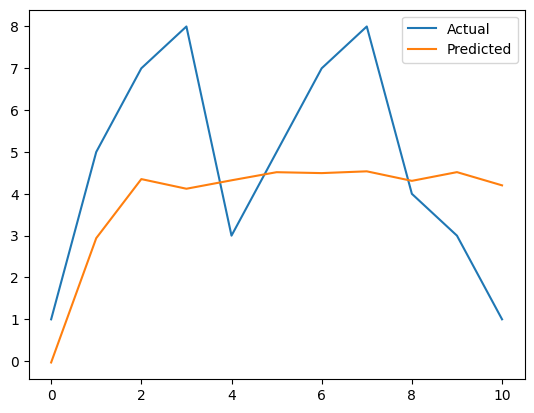

In [41]:
import matplotlib.pyplot as plt

plt.plot( result_dict_3m.get('result')['y'].values, label='Actual')
plt.plot( result_dict_3m.get('result')['yhat'].values, label='Predicted')
plt.legend()
plt.show()

In [32]:
result_dict_3m.keys()

dict_keys(['descript', 'result', 'final', 'model', 'accuracy'])

In [38]:
result_dict_3m.get('accuracy')

72.72727272727273

In [42]:
result_dict_3m.get('final')

,ds,days,hour,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly,right
0,2023-04-03 00:00:00,Monday,0,1.0,-0.031626,-1.236989,1.225719,1.031626,2.462708,Yes,True
1,2023-04-03 09:00:00,Monday,9,5.0,2.940107,1.744947,4.221393,2.059893,2.476445,No,True
2,2023-04-03 10:00:00,Monday,10,7.0,4.351920,3.068357,5.663189,2.648080,2.594832,Yes,False
3,2023-04-03 11:30:00,Monday,11,8.0,4.121271,2.830429,5.409739,3.878729,2.579310,Yes,False
4,2023-04-03 12:00:00,Monday,12,3.0,4.322911,2.977122,5.631539,-1.322911,2.654417,No,True
5,2023-04-03 13:30:00,Monday,13,5.0,4.516895,3.284466,5.792461,0.483105,2.507995,No,True
6,2023-04-03 14:00:00,Monday,14,7.0,4.495091,3.187750,5.722580,2.504909,2.534830,No,True
7,2023-04-03 15:00:00,Monday,15,8.0,4.537565,3.182448,5.763656,3.462435,2.581208,Yes,False
8,2023-04-03 16:30:00,Monday,16,4.0,4.309968,3.136050,5.565134,-0.309968,2.429085,No,True
9,2023-04-03 17:30:00,Monday,17,3.0,4.518294,3.385829,5.752012,-1.518294,2.366183,No,True


> ##### End Of File #####

> ##### plotly #####

In [ ]:
# fig = px.line( gen_df.reset_index(), x='ds', y='y', title='anomaly')
# #slider
# fig.update_xaxes(
#     rangeslider_visible = True,
#     rangeselector = dict(
#         buttons = list([
#               dict(count=1, label='1y', step="year", stepmode="backward"),
#               dict(count=2, label='2y', step="year", stepmode="backward"),
#         ])
#     )
# )
# fig.show()

### Test data biz_log_summary ###

> ##### Load data biz_log_summary #####

In [4]:
import pandas as pd

# 1 분 단위로 count 된 log 
filename = '../ai-plus-test-data/logs_skahn_2.csv'
df = pd.read_csv( filename, sep=',', engine='python')
df.columns = [ 'ds', 'y' ]

df.ds = pd.to_datetime(df['ds'], format='%Y%m%d-%H%M')

FileNotFoundError: [Errno 2] No such file or directory: '../ai-plus-test-data/logs_skahn_2.csv'

In [ ]:
df

,ds,y
0,2023-02-01 09:00:00,2
1,2023-02-01 09:01:00,1
2,2023-02-01 09:02:00,2
3,2023-02-01 09:03:00,2
4,2023-02-01 09:04:00,2
...,...,...
27559,2023-05-02 17:54:00,2
27560,2023-05-02 17:55:00,5
27561,2023-05-02 17:57:00,2
27562,2023-05-02 17:58:00,2


> ##### split data train, valid #####

In [ ]:
from dateutil.parser import *
import pickle

df_train = df.loc[ df.ds < parse( '2023-05-02 00:00:00' ),]
df_valid = df.loc[ df.ds > parse( '2023-05-02 00:00:00' ),]

> ##### Load data test #####

In [ ]:
with open( '../ai-plus-test-data/test_data.pickle', 'rb') as fr:
    df_test = pickle.load( fr )

In [ ]:
fig1 = px.scatter( df_train, x='ds', y='y', title='Train data' )
fig2 = px.scatter( df_valid, x='ds', y='y', title='Valid data' )
fig3 = px.scatter( df_test, x='ds', y='y', title='Total test data',  )
fig1.show()
fig2.show()
fig3.show()

In [ ]:
np.sum( df.y ), np.sum( df_train.y ), np.sum( df_valid.y ), np.sum(df_test.y)
print( 
    f'''
    data : 

     - 91 일          데이터 : about {np.sum( df.y )} ea
        - 90 일 train 데이터 : about {np.sum( df_train.y )} ea
        -  1 일 valid 데이터 : about {np.sum( df_valid.y )} ea
     -  1 day    test 데이터 : 최소 100 ea
        -  1 일  test 데이터 : about {np.sum( df_test.y )} ea

    
    request -> polling : minimum 1 min / user 
    Maximum user 수와 log 에 따라 상이할 수 있음.

    - accuracy 지표 
      - 시간내 과 접속 인 비정상 log 검출 비율 80 %
      - 시간외 비정상 접속 log 검출 비율 80 %

    '''
)


    data : 

     - 91 일          데이터 : about 84536 ea
        - 90 일 train 데이터 : about 83121 ea
        -  1 일 valid 데이터 : about 1415 ea
     -  1 day    test 데이터 : 최소 100 ea
        -  1 일  test 데이터 : about 972 ea

    
    request -> polling : minimum 1 min / user 
    Maximum user 수와 log 에 따라 상이할 수 있음.

    - accuracy 지표 
      - 시간내 과 접속 인 비정상 log 검출 비율 80 %
      - 시간외 비정상 접속 log 검출 비율 80 %

    


> ##### Test run_to_predict #####

In [ ]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import plotly.express as px
import numpy as np

from sklearn import metrics

def run_to_predict(  ts, test_data, period :str, holiday ):   
    ts = ts.set_index('ds').resample( period ).mean().reset_index()

    print( f'ts.shape : {ts.shape}' )
    # print( f'train.shape : {train.shape}' )
    # print( f'test.shape : {test.shape}' )
    
    m = Prophet(
        
        growth='linear',
        # growth='logistic',
        # growth='flat',
    
        ## trend
        # changepoints=None,
        # n_changepoints=25,
        changepoint_range=0.9,    
        changepoint_prior_scale=0.05,
        
        ## seasonality
        # seasonality_mode='multiplicative',
        seasonality_mode='additive', # additive
        seasonality_prior_scale=10.0, # 10
        daily_seasonality=10,
        weekly_seasonality=10,
        # daily_seasonality=True,
        # weekly_seasonality=True,
        # yearly_seasonality=True,
        
        ## holiday
        # holidays=holiday,
        # holidays_prior_scale=10,
        
        ## Others
        interval_width = 0.95,        
        # mcmc_samples = 300,
        # uncertainty_samples=1000,
        
    )

    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

    # m.fit(train)
    # 2 년치 훈련 전부함.
    m.fit(ts)

    ## if `growth=logistic'
    # test_data['cap'] = ts.y.max()
    # test_data['floor'] = 0.0
    
    ats = test_data.set_index('ds').resample( period ).mean().reset_index()
    print(ats.shape)
    ats.dropna(inplace=True)

    forecast = m.predict( ats )
    
    fig = m.plot( forecast  )
    a = add_changepoints_to_plot(fig.gca(), m, forecast)
        
    forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

    result = pd.concat([ats.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)

    ## metrix
    # begin
    r2_score = metrics.r2_score(list(result['y']), list(result['yhat']))
    mae = metrics.mean_absolute_error(list(result['y']), list(result['yhat']))
    mse = metrics.mean_squared_error(list(result['y']), list(result['yhat']))

    print(f'r2_score : {r2_score}')
    print(f'mae : {mae}')
    print(f'mse : {mse}')
    # end

    result['error'] = result['y'] - result['yhat']
    result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']

    result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)

    # result['anomaly'] = result.apply(lambda x: 'Yes' if( np.abs(x['yhat_upper']) - np.abs(x['yhat_lower']) ) * 1.5 < ( np.abs(x['y']) - np.abs(x['yhat']) ) else 'No', axis = 1)
    # result['anomaly'] = result.apply(lambda x: 'Yes' if( np.abs(x['y']) - np.abs(x['yhat']) ) > ( np.abs(x['yhat_upper']) - np.abs(x['yhat_lower']) ) else 'No', axis = 1)
    # result['anomaly'] = result.apply(lambda x: 'Yes' if( np.abs( np.abs(x['y']) - np.abs(x['yhat']) ) ) > np.abs( ( np.abs(x['yhat_upper']) - np.abs(x['yhat_lower']) ) ) else 'No', axis = 1)

    # def custom( hour, y, yhat, yupper, ylower ):
    #     # print( f'index ds : [{hour}]')
    #     if 7 < hour < 23:
    #         return 'yes' if y > ( yupper + ylower ) * 2.0 else 'no'
    #     else:
    #         return 'yes' if y > ( yupper + ylower ) / 2 * 0.7 else 'no'
        
    result.reset_index( inplace=True)

    # result['anomaly'] = result.apply(lambda x: custom( x['ds'].hour, x['y'], x['yhat'], x['yhat_upper'], x['yhat_lower'] ), axis = 1 )

    # ( np.abs(final_df.y) - np.abs(final_df.yhat) ) - ( np.abs(final_df.yhat_upper) - np.abs(final_df.yhat_lower) ) 
        

    fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title=f'{period} tick graph')
    fig.show()

    ats_data = result.loc[result.anomaly == 'Yes',]

    print( f'Anomaly data shape : {ats_data.shape}' )
    
    final = result.reset_index()
    final['days'] = final['ds'].dt.day_name()
    final['hour'] = final.ds.dt.hour
    # final['right'] = final.apply( lambda x: ((x.days in ['Saturday', 'Sunday']) | ((x.hour >= 9) & (x.hour <= 18) ) ) == (x.anomaly == 'Yes'), axis=1)
    final['right'] = final.apply( lambda x: not ((x.days in ['Saturday', 'Sunday']) | ( x.hour not in range( 9, 19 )) ) ^ (x.anomaly == 'Yes'), axis=1)
    
    
    final = final[['ds', 'days', 'hour', 'y', 'yhat', 'yhat_lower', 'yhat_upper', 'error', 'uncertainty',
        'anomaly', 'right']]
    
    accuracy = final.loc[ final.right, ].shape[0] / final.shape[0] * 100
    
    return {
                'descript' : f'{period} tick test',
                'result'   : result,
                'final'    : final,
                'model'    : m,
                'accuracy' : accuracy,
                
            }

ts.shape : (128700, 2)


16:03:22 - cmdstanpy - INFO - Chain [1] start processing
16:03:32 - cmdstanpy - INFO - Chain [1] done processing


(540, 2)
r2_score : -0.11703078670176703
mae : 1.5277112218730207
mse : 4.3884424977852206


Anomaly data shape : (0, 8)


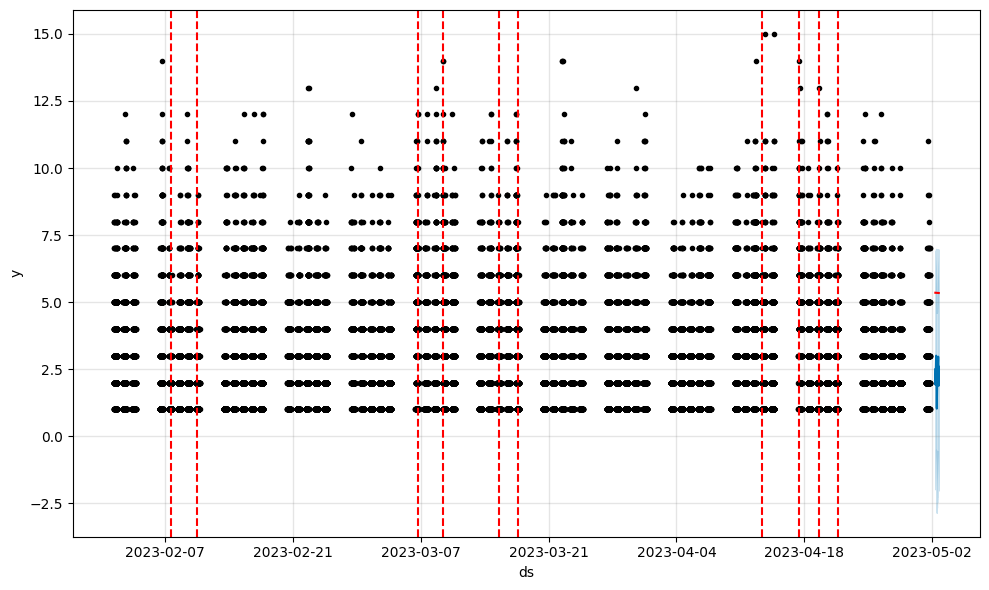

In [ ]:
holiday = get_holidays( '2023-02-01', '2023-05-02' )
result_dict = run_to_predict(df_train, df_valid, '1T', holiday)

In [ ]:
result_dict.keys()

dict_keys(['descript', 'result', 'final', 'model', 'accuracy'])

In [ ]:
result_dict['result']

,ds,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly
0,2023-05-02 09:00:00,5.0,2.493412,-1.320225,5.895306,2.506588,7.215530,No
1,2023-05-02 09:01:00,3.0,2.421808,-1.250985,5.906639,0.578192,7.157624,No
2,2023-05-02 09:02:00,2.0,2.355912,-1.243749,5.858056,-0.355912,7.101805,No
3,2023-05-02 09:03:00,9.0,2.295526,-1.682786,6.084537,6.704474,7.767324,No
4,2023-05-02 09:04:00,4.0,2.240449,-1.361017,5.876033,1.759551,7.237050,No
...,...,...,...,...,...,...,...,...
453,2023-05-02 17:54:00,2.0,2.252406,-1.828679,5.834159,-0.252406,7.662838,No
454,2023-05-02 17:55:00,5.0,2.309439,-1.320519,5.954531,2.690561,7.275050,No
455,2023-05-02 17:57:00,2.0,2.438223,-1.358957,6.321715,-0.438223,7.680672,No
456,2023-05-02 17:58:00,2.0,2.510262,-1.492767,6.161432,-0.510262,7.654199,No


In [ ]:
result_dict['final'][ result_dict['final'].anomaly == 'yes' ]

,ds,days,hour,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly,right


In [ ]:
result_dict['accuracy']

100.0

In [ ]:
from sklearn import metrics

r2_score = metrics.r2_score(list(test['y']), list(forecast.loc[1400:,'yhat']))
mae = metrics.mean_absolute_error(list(test['y']), list(forecast.loc[1400:,'yhat']))
mse = metrics.mean_squared_error(list(test['y']), list(forecast.loc[1400:,'yhat']))

print(f'r2_score : {r2_score}')
print(f'mae : {mae}')
print(f'mse : {mse}')

NameError: name 'test' is not defined